# Plot evaluations of sounding data

https://weather.uwyo.edu/upperair/sounding.html

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 12})
import xarray as xr
import pandas as pd

from datetime import datetime
from datetime import timedelta

# meteorology - specific
from metpy.calc import relative_humidity_from_dewpoint
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

import sys
sys.path.append('./scripts/')

from LIB_dates import generate_date_list
from LIB_request_WUA_sounding import check_for_WUA_soundings
from LIB_sounding_analysis import interpolate_soundings
from LIB_sounding_date_checks import grab_sounding_dates

### Plot frequency of RH threshold passed seasonall as a function of height

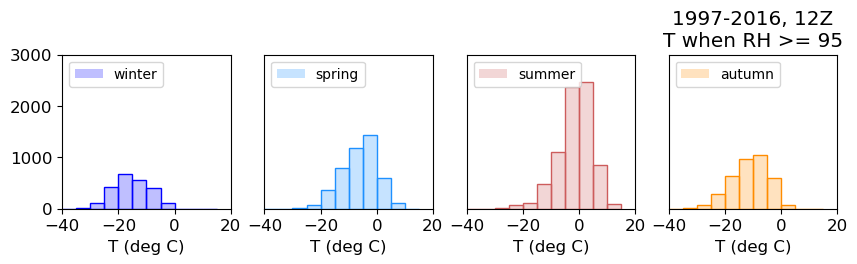

In [2]:
#==================================================
seasons = ['winter', 'spring', 'summer', 'autumn']
colors = ['blue', 'dodgerblue', 'indianred', 'darkorange']
rh_thresh = 95
hours = [12]
#============================================================

fig, axs = plt.subplots(1,len(seasons), figsize=(10,2))

for ss, season in enumerate(seasons):

    # open seasonal data
    ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')

    # plot histograms
    axs[ss].hist(ds.T.values[ds.RH >= rh_thresh], bins=np.arange(-40,20,5), edgecolor='None', facecolor=colors[ss], alpha=0.25, label=f'{season}')
    axs[ss].hist(ds.T.values[ds.RH >= rh_thresh], bins=np.arange(-40,20,5), edgecolor=colors[ss], facecolor='None', alpha=1)
    
    # labels
    axs[ss].set_xlabel('T (deg C)')
    axs[ss].set_xlim(-40,20)
    axs[ss].set_ylim(0,3000)
    if ss > 0:
        axs[ss].set_yticks([])
    else:
        plt.title(f'{ds.year[0].values}-{ds.year[-1].values}, {hours[0]}Z\nT when RH >= {rh_thresh}')
    
    # legends
    axs[ss].legend(fontsize=10, loc=2)


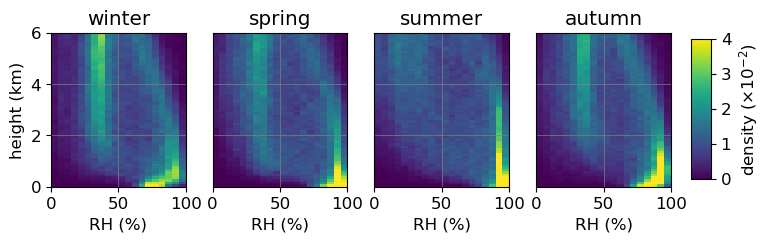

In [3]:


rh_thresh = 90
bin_edges = np.arange(0,105,5)
bin_centers = np.arange(2.5,100,5)



fig, axs = plt.subplots(1,len(seasons), figsize=(8,2))

for ss, season in enumerate(seasons):

    # open seasonal data
    ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')

    
    # create density histogram at each height (integral across RH bins == 1)
    # across all non-nan values
    H = ds.h.values
    HIST = np.array([])

    for hh, HH in enumerate(H):
        RH_vals = ds.RH.sel(h=HH).values
        the_hist = np.histogram(RH_vals[np.isnan(RH_vals) == False], bins = bin_edges, density=True);
        HIST = np.append(HIST, the_hist[0])

    # reshap histograms into grids
    HIST = np.reshape(HIST, (len(H),len(bin_centers)))
    rh, height = np.meshgrid(bin_centers, H)
    
    axs[ss].set_title(f'{season}')
    dens = axs[ss].pcolormesh(rh, height, HIST*100, vmin=0, vmax=4)
    
    # guidelines
    axs[ss].vlines(50, 0, 6, colors='gray', linewidths=0.5)
    axs[ss].hlines(4, 0, 100, colors='gray', linewidths=0.5)
    axs[ss].hlines(2, 0, 100, colors='gray', linewidths=0.5)
    
    # threshold
#     axs[ss].vlines(rh_thresh, 0., 6, colors='lightgray', linestyle='dashed')
    
    axs[ss].set_xlabel('RH (%)')
    
    if ss == 0:
        axs[ss].set_ylabel('height (km)')
    else:
        axs[ss].set_yticks([])
    
# colorbar
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
fig.colorbar(dens, label='density ($\\times 10^{-2}$)', cax=cbar_ax)

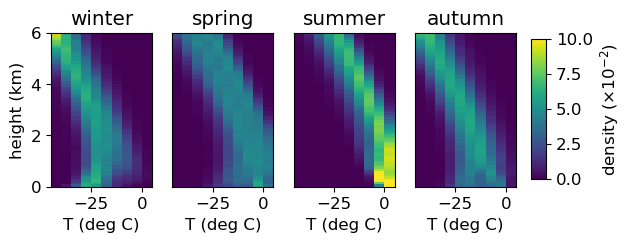

In [15]:

# WRONG BINS
rh_thresh = 90
# bin_edges = np.arange(-45,10,5)
# bin_centers = np.arange(-42.5,5,5)



fig, axs = plt.subplots(1,len(seasons), figsize=(6,2))

for ss, season in enumerate(seasons):

    # open seasonal data
    ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')

    
    # create density histogram at each height (integral across RH bins == 1)
    # across all non-nan values
    H = ds.h.values
    HIST = np.array([])

    for hh, HH in enumerate(H):
        T_vals = ds.T.sel(h=HH).values
        the_hist = np.histogram(T_vals[np.isnan(T_vals) == False], bins = bin_edges, density=True);
        HIST = np.append(HIST, the_hist[0])

    # reshap histograms into grids
    HIST = np.reshape(HIST, (len(H),len(bin_centers)))
    rh, height = np.meshgrid(bin_centers, H)
    
    axs[ss].set_title(f'{season}')
    dens = axs[ss].pcolormesh(rh, height, HIST*100, vmin=0, vmax=10)
    
    # guidelines
#     axs[ss].vlines(50, 0, 6, colors='gray', linewidths=0.5)
#     axs[ss].hlines(4, 0, 100, colors='gray', linewidths=0.5)
#     axs[ss].hlines(2, 0, 100, colors='gray', linewidths=0.5)
    
    # threshold
#     axs[ss].vlines(rh_thresh, 0., 6, colors='lightgray', linestyle='dashed')
    
    axs[ss].set_xlabel('T (deg C)')
    
    if ss == 0:
        axs[ss].set_ylabel('height (km)')
    else:
        axs[ss].set_yticks([])
    
# colorbar
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
fig.colorbar(dens, label='density ($\\times 10^{-2}$)', cax=cbar_ax)

Text(0.5, 1.0, '1997-2016, 12Z\nRH >= 90')

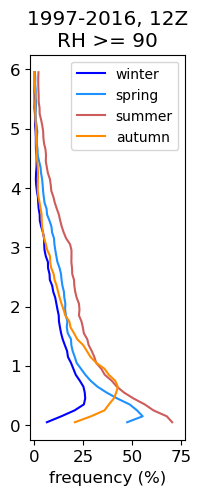

In [6]:


seasons = ['winter', 'spring', 'summer', 'autumn']
colors = ['blue', 'dodgerblue', 'indianred', 'darkorange']
rh_thresh = 90


fig, ax = plt.subplots(figsize=(2,5))
assert len(hours) == 1, 'error in title with multiple hours'
ax.set_xlabel('frequency (%)')
ax.set_xlim(-2,77)
ax.set_xticks([0,25,50,75])


for ss, season in enumerate(seasons):

    # open seasonal data
    ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')
    
    # find number of days above threshold
    above_thresh = (ds.RH >= rh_thresh).sum(dim='doy').sum(dim='year')
    
    # find total number of days with observations
    total_obs = (np.isnan(ds.RH[:,:,:])==False).sum(dim='doy').sum(dim='year')
    
    # plot
    ax.plot(100*above_thresh/total_obs, ds.h, c=colors[ss], label=f'{season}')
    
plt.legend(fontsize=10)
ax.set_title(f'{ds.year[0].values}-{ds.year[-1].values}, {hours[0]}Z\nRH >= {rh_thresh}')

# fig.savefig(f'./figures/RH{rh_thresh}_freq_{season}_{years[0]}-{years[-1]}.png', 
#             transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)
#